<a href="https://colab.research.google.com/github/c820306/Alpha_camp_recommentation/blob/main/Week3_2_cf_item_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Code

## 基礎建設

In [ ]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [ ]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

In [ ]:
# metadata = getDF('/content/meta_All_Beauty.json.gz')
# ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata = getDF('./meta_All_Beauty.json.gz')
ratings = pd.read_csv('./All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [ ]:
metadata.head(3)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]


In [ ]:
ratings.head(3)

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800


## 資料整理

### 調整日期格式

In [ ]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

* 發現ratings_trainings有同一個客戶有同天同產品評價分數相同的狀況： 共9,070筆

In [ ]:
print(f"repeated rating of product:  {ratings_trainings.shape[0]- ratings_trainings.drop_duplicates().shape[0]}")

repeated rating of product:  9070


* 排除重複評價資料

In [ ]:
ratings_trainings = ratings_trainings.drop_duplicates()

In [ ]:
df = ratings_trainings.groupby(['reviewerID','asin'],as_index=False).agg(count=('reviewerID','count'))
repeated_purchase_product_users = df[ df['count']> 1]['reviewerID'].unique()
repeated_purchase_product = df[df['count']>1]['asin'].unique()

* 共603位客戶曾購買同一個商品(not on same day), 被重複購買商品數有153個
* 重複評價分數會影響後續user_to_item、item_to_user，採用最近的商品評價，共670筆排除

In [ ]:
print(f"the number of user for repeated purchase the same product: {len(repeated_purchase_product_users)}")
print(f"the number of product for being repeated purchased: {len(repeated_purchase_product)}")

the number of user for repeated purchase the same product: 603
the number of product for being repeated purchased: 153


In [ ]:
df = ratings_trainings[ratings_trainings['reviewerID'].isin(repeated_purchase_product_users)&
                  ratings_trainings['asin'].isin(repeated_purchase_product)
                 ].sort_values(['reviewerID','asin','DATE'], ascending=[True,True,False])
df

,asin,reviewerID,overall,unixReviewTime,DATE
12244,B00011QUDE,A108DY5IC7OVWT,3.0,1473552000,2016-09-11
12245,B00011QUDE,A108DY5IC7OVWT,1.0,1473552000,2016-09-11
74633,B001E5PLCM,A10CKOFTMAV45W,3.0,1356393600,2012-12-25
74634,B001E5PLCM,A10CKOFTMAV45W,4.0,1355270400,2012-12-12
90436,B002OITLG0,A10DOJIAIUIAEB,5.0,1519948800,2018-03-02
...,...,...,...,...,...
226967,B01AAVIO38,AZBLP8S3CHH3,4.0,1460160000,2016-04-09
193603,B00W259T7G,AZBOC8H7QQGJC,3.0,1436313600,2015-07-08
193749,B00W259T7G,AZBOC8H7QQGJC,4.0,1422489600,2015-01-29
194060,B00W259T7G,AZWIAYHWL2FWE,4.0,1395100800,2014-03-18


In [ ]:
keep = df.drop_duplicates(subset=['asin','reviewerID'],keep='first').index
repeated_drop_set = set(df.index) - set(keep)
keep_list = list(set(ratings_trainings.index) - repeated_drop_set)

print(f"the number of repeated purchase not recently--> delete: {len(repeated_drop_set)}")

the number of repeated purchase not recently--> delete: 670


In [ ]:
ratings_trainings = ratings_trainings.loc[keep_list]
ratings_trainings.shape

(361012, 5)

## 資料切分

In [ ]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

## Item-based：產生推薦

In [ ]:
import pandas as pd
from itertools import combinations
from collections import defaultdict

def recommender(ratings_trainings, users=[], k=50):

    # loading data from dataframe
    # item_to_users dict:
    # {
    #   'item': {
    #       'user': ratings...
    #   }...
    # }
    item_to_users = defaultdict(dict)
    for _, row in ratings_trainings.iterrows():
        
        row = dict(row)
        user = row['reviewerID']
        item = row['asin']
        rating = float(row['overall'])
        item_to_users[item][user] = rating

    print("data converted")

    user_to_items = defaultdict(dict)
    for item, rating_users in item_to_users.items():
        for user, rating in rating_users.items():
            user_to_items[user][item] = rating

    print("data inverted")

    init_sim = lambda: [0, 0, 0]
    factory = lambda: defaultdict(init_sim)
    pre_item_similarity = defaultdict(factory)
    for user, items in user_to_items.items():
        if len(items) > 1:
            for i1, i2 in combinations(items.keys(), 2):
                xy = items[i1] * items[i2]
                xx = items[i1] ** 2
                yy = items[i2] ** 2
                pre_item_similarity[i1][i2][0] += xy
                pre_item_similarity[i1][i2][1] += xx
                pre_item_similarity[i1][i2][2] += yy

                pre_item_similarity[i2][i1][0] += xy
                pre_item_similarity[i2][i1][1] += xx
                pre_item_similarity[i2][i1][2] += yy

    print("sim data prepared")

    item_similarity = {}
    for src_item in pre_item_similarity:
        item_similarity_order = []
        for dst_item, val in pre_item_similarity[src_item].items():
            xy = val[0]
            xx = val[1]
            yy = val[2]
            div = ((xx*yy) ** 0.5)
            if div == 0:
                continue
            similarity = xy / div
            if similarity < 0:
                continue
            for i, s in enumerate(item_similarity_order):
                target_similarity = s[1]
                if target_similarity < similarity:
                    item_similarity_order.insert(i, (dst_item, similarity))
                    break
            else:
                item_similarity_order.append((dst_item, similarity))
        item_similarity[src_item] = item_similarity_order

#     print(f"get {k} recommendation items for for user: {users}")

    recommendation = {}
    for user in users:
        items = []
        items_set = set()
        stop = False
        user_has_rated = set(user_to_items[user])
        for item in user_has_rated:
            if item in item_similarity:
                for sim_item, _ in item_similarity[item]:
                    if sim_item not in user_has_rated and sim_item not in items_set:
                        items.append(sim_item)
                        items_set.add(sim_item)
                    if len(items) >= k:
                        stop = True
                        break
                if stop:
                    break
        recommendation[user] = items
    return recommendation    

ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

data converted
data inverted
sim data prepared


{'A100XQFWKQ30O2': [],
 'A103T1QOGFCSEH': [],
 'A106UKKSJ2KXPF': [],
 'A10A7GV4D5A11V': [],
 'A1119JJ37ZLB8R': [],
 'A113UOOLBSZN52': [],
 'A12M4U7WK4ALCR': [],
 'A12T8YTW6VWT7S': [],
 'A1364JXGKB46MM': [],
 'A137DALOQFKBTI': [],
 'A13FEZ3WV7S2EY': [],
 'A13IV4I1B0RXMG': [],
 'A13JU88JAHN72I': ['B00BWIT33Y'],
 'A13K55R6VH1OOD': [],
 'A13P7VFU075A': [],
 'A13SWYE4QLB6NG': [],
 'A13ZTQ0Q4ATA41': [],
 'A142EDN04OD62U': [],
 'A142I22FIC8MZK': [],
 'A14834QTII5TLT': [],
 'A14A447VPACTBC': [],
 'A14AP6MN5XO6LB': [],
 'A14CLF25IX25US': [],
 'A14LYXC3HTBAHI': [],
 'A14VUW4KZ34EOE': [],
 'A14Y32P26G9YL': [],
 'A157T25PBS7MX4': [],
 'A15HZDSERD85C8': [],
 'A15JJ8J1FGADIX': [],
 'A15ZCL70JXXH89': [],
 'A1617KN2IAWZ6J': [],
 'A16E0O88262HKA': [],
 'A16NSZ58PTVIYF': [],
 'A16UGDXRTDLJG5': [],
 'A16X9HR3UFQQXY': [],
 'A16Y7V1CZCWKFV': ['B000EE9XYG',
  'B007SA3AUW',
  'B000FVHRXC',
  'B001U4RGOS',
  'B01CRWLLX8',
  'B004E4GHRS',
  'B006IB5T4W',
  'B00B0SA1SC',
  'B00JYGWWIO',
  'B00L88S190',
  'B00X7

## Item-based結果評估

In [ ]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))
            
            if len(set(ratings_by_user[d])) > 0:
                if len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))> 0:
                    print(f'user: {d} , Match!!!')
                    print("recommendation: ",  ratings_by_user[d])
                    print("real buy: ",  ratings_testings_by_user[d] )
                    print()
                else: 
                    print(f'user: {d} , Not match!!!')
                    print("recommendation: ",  ratings_by_user[d])
                    print("real buy: ",  ratings_testings_by_user[d] )
                    print()

    score = total / len(ratings_testings)
    return score

score = evaluate(ratings_testings_by_user, ratings_by_user)
print(f"The evaluation result is {score}")

user: A13JU88JAHN72I , Not match!!!
recommendation:  ['B00BWIT33Y']
real buy:  ['B017I6B6GK']

user: A16Y7V1CZCWKFV , Not match!!!
recommendation:  ['B000EE9XYG', 'B007SA3AUW', 'B000FVHRXC', 'B001U4RGOS', 'B01CRWLLX8', 'B004E4GHRS', 'B006IB5T4W', 'B00B0SA1SC', 'B00JYGWWIO', 'B00L88S190', 'B00X7G1CII', 'B00XC8OIDC', 'B00M8RRUSS', 'B00NV5QEEC', 'B00NV6DMG4', 'B00X3T6FEU', 'B017BJ8KFE', 'B01DKI8S1Q', 'B00NW5H3V4', 'B00V82AG0S', 'B00WMP9V5G', 'B017CHORY8', 'B01C4ZAPGM', 'B01ENSF702', 'B019RF59O0', 'B01BEWYRJ2', 'B01C3UL1ZM', 'B00S86RLV4', 'B01E0T6BPE', 'B01H71NDT4', 'B00BEJFWPO', 'B00IPI0IYM', 'B00LSS8IIE', 'B00NS8YAHU']
real buy:  ['B01E54U1RI']

user: A19503XX7GU6J2 , Not match!!!
recommendation:  ['B000142ZFS', 'B006GESCPY', 'B013OJ04GI', 'B019Z9KCUO', 'B019Z9JUC0', 'B019Z9L8PW', 'B019Z9L30W', 'B019Z9L6MC', 'B001DKQ47E', 'B0067F28ZW', 'B00NS8YAHU', 'B017X1I53M', 'B00R2TO8AK', 'B0145TJAPC', 'B015DZXQKC', 'B019DWCJDG', 'B0132W3VPI', 'B01FTG8WBS', 'B01G6BTZLG', 'B01DWBI43I', 'B00DZSLA12', 

In [ ]:
print(f' {len([user for user in ratings_by_user if len(ratings_by_user[user])>0 ])} users have recommendations')

 32 users have recommendations


## Item-based：結果分析

In [ ]:
users_38_df = ratings_trainings[ratings_trainings['reviewerID'].isin(ratings_testings['reviewerID'])]
users_38_user = users_38_df['reviewerID'].unique()

In [ ]:
print(f"First, among {len(ratings_by_user)} testing users, there are only {len(users_38_user)} user have purchase records between 2000 and 2018.")

First, among 584 testing users, there are only 38 user have purchase records between 2000 and 2018.


In [ ]:
users_38_df = users_38_df.groupby(['reviewerID']).agg(list).reset_index()[['reviewerID','asin']]
users_38_df['count'] = users_38_df['asin'].apply(lambda x : len(x))

In [ ]:
users_38_df

,reviewerID,asin,count
0,A13JU88JAHN72I,[B009YDVB6Q],1
1,A16Y7V1CZCWKFV,[B015ZOWER2],1
2,A19503XX7GU6J2,"[B019Z9LD98, B019Z9LAPK]",2
3,A1EY751AUVO5NZ,[B01ENDFXJW],1
4,A1PR178735XC70,[B00NNLURMY],1
5,A1SA3N793WT2LM,"[B0054H0NZ6, B007EITOSK, B0075OYLKY, B012TQ6AXS]",4
6,A1TP9JHTIY468V,"[B01E6NITSG, B01CTKQL56]",2
7,A1UAOE8KO7Q1DZ,[B006NXZ7TC],1
8,A1WEFBEJ7OHSVZ,[B002OITLG0],1
9,A1WSZED2O5MA5T,[B000WYJTZG],1


In [ ]:
purchase_item = list(ratings_trainings['asin'].unique())
print(f"The number of product item: {len(purchase_item)}")

The number of product item: 32582


In [ ]:
user_to_items = defaultdict(dict)
for _, row in ratings_trainings.iterrows():
    row = dict(row)
    user = row['reviewerID']
    item = row['asin']
    rating = float(row['overall'])
    user_to_items[user][item] = rating

count = lambda : [0]
item_count = lambda : defaultdict(count)
item2item_count = defaultdict(item_count)
for user, item2rating in user_to_items.items():
    for item1, item2 in combinations(item2rating.keys(),2):
        item2item_count[item1][item2][0] += 1
        item2item_count[item2][item1][0] += 1

print(f"The number of product have purchased together: {len(item2item_count)}")

The number of product have purchased together: 11038


In [ ]:
no_pairs_item = [item for item in purchase_item if item not in item2item_count]
print(f"The number of product don't have purchased together: {len(no_pairs_item)}")

The number of product don't have purchased together: 21544


* 發現共32,582商品有購買紀錄，但每項商品可能僅被一個使用者購買，或該商品沒有其他使用者同時購買其他商品,符合上述樣態的商品就不會納入item-based推薦

In [ ]:
user_no_recommendation = {i['reviewerID']: i['asin'] for i in users_38_df.to_dict('records') for item in i['asin'] if item in no_pairs_item}
print(f"Secondly, There are {len(user_no_recommendation)} users who purchased only one product which doesn't be purchased with remaining products by other user")
user_no_recommendation

Secondly, There are 6 users who purchased only one product which doesn't be purchased with remaining products by other user


{'A1UAOE8KO7Q1DZ': ['B006NXZ7TC'],
 'A2GFPTQ4VWDX96': ['B012BG2TIG'],
 'A3GRQ9WMP4OXFE': ['B00D7C9YQ4'],
 'A7JUHUYLXIUVQ': ['B00BOJKTM0'],
 'A7Y4ETTLARUGI': ['B00IUOH3KS'],
 'AQYL4TDY2HU8Z': ['B003B6QR5M']}

### 分析38位用戶所購買的商品

In [ ]:
## 比較用戶購買的商品在近一個月的商品銷量落點
df = ratings[(ratings['DATE']>='2018-08-01')& (ratings['DATE']<='2018-08-31')]['asin'].value_counts().to_frame().reset_index().rename(columns={'index':'asin','asin':'sale_count'})
## 列出商品的排名
asin_2_sale_count = {i['asin']: i['sale_count'] for i in df.to_dict("records")}

## mapping38位用戶所購買的商品與對應近一個月商品銷量
asin_2_sale_count_38user = ratings_testings[ratings_testings['reviewerID'].isin(users_38_df['reviewerID'].tolist())]
asin_2_sale_count_38user['sale_count']= asin_2_sale_count_38user['asin'].map(asin_2_sale_count)
                                         

<ipython-input-287-100d11714148>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asin_2_sale_count_38user['sale_count']= asin_2_sale_count_38user['asin'].map(asin_2_sale_count)


In [ ]:
print(df.head(20))
print(df.shape)

          asin  sale_count
0   B01DKQAXC0          75
1   B00W259T7G          53
2   B013XKHA4M          29
3   B012Z7IHHI          26
4   B01DLR9IDI          26
5   B01AVJCDYA          24
6   B0195R1FT8          23
7   B01CJNZKZK          22
8   B018WCT01C          13
9   B0119Q9FYU          12
10  B0168SXRR0          12
11  B01C39X6TW          12
12  B017BJ8KFE          11
13  B0175PT3KK          11
14  B01DDQXRWU          11
15  B00SZPM4ZQ          11
16  B017M402PO          10
17  B01DFHDMS6          10
18  B01ES87TOY          10
19  B00X4DKZKU          10
(826, 2)


* 近一個商品銷量若銷量>=10，則可納入Top20排名

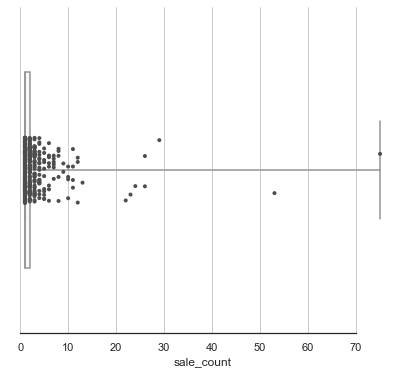

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(7, 6))

sns.boxplot(x= 'sale_count', data=df,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x= 'sale_count', data=df,
              size=4, color=".3", linewidth=0) 

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

* 38位user中，發現有6位user所購買的商品在近一個月銷量>= 10，表示若僅提升38位用戶的推薦成效，仍建議使用rule-base會有較佳成效

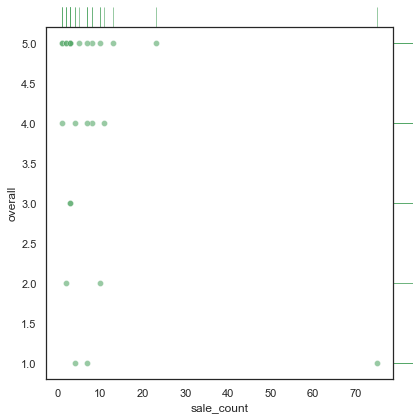

In [ ]:
import seaborn as sns
sns.set_theme(style="white", color_codes=True)
mpg = sns.load_dataset("mpg")

# Use JointGrid directly to draw a custom plot
g = sns.JointGrid(data=asin_2_sale_count_38user, x="sale_count", y="overall", space=0, ratio=17)
g.plot_joint(sns.scatterplot, sizes=(60, 120),
             color="g", alpha=.6, legend=False)
g.plot_marginals(sns.rugplot, height=1, color="g", alpha=.6)

In [ ]:
asin_2_sale_count_38user[asin_2_sale_count_38user['sale_count']>=10]

,asin,reviewerID,overall,unixReviewTime,DATE,sale_count
240463,B01DKQAXC0,A2M4YSOJZELJ6N,1.0,1536278400,2018-09-07,75.0
346958,B018WCT01C,A1WSZED2O5MA5T,5.0,1536883200,2018-09-14,13.0
347568,B0195R1FT8,A28E3FNV1BYC94,5.0,1536451200,2018-09-09,23.0
359679,B01DDQXRWU,ATJRZUXNWAWIK,4.0,1536624000,2018-09-11,11.0
364129,B01ES87TOY,AITF34BGBMVJJ,5.0,1536192000,2018-09-06,10.0
364131,B01ES87TOY,AGRZQOBCF8H87,2.0,1536019200,2018-09-04,10.0


#### Conclusion

* item-based推薦準度為0.169%
* item-based可進行推薦的基礎，主要建構於該商品有被評價，並同時與其他商品被用戶評價的前提下才能成立，依照資料集EDA，因為有部份產品僅購買一次並未被其他user同時購買其他產品，導致推薦成效不佳
* 另外有38位用戶中，其購買之產品有部分主要為近一個月熱銷品，因此使用rule-based表現更佳